FYS-STK project 2\
By David Svejda, Gianmarco Puleo and Henrik Breitenstein

All of the results are generated from scripts in this file

# Finding suitable parameter values

We start by optimising the learningrate, the number of epochs and the regularisation parameter lambda for stochastic gradient descent. First we optimise the learning rate and number of epoch with a small regularisation parameter by looking at how the accuracy and cross-entropy changes based on the parameters.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import NeuralNet as NN
import optimisers as op
import ActivationFunctions as AF
import pandas as pd
import Data
import lrSchedules as lrs

ln10 = np.log(10)

def Accuracy(predictions, targets):
    numbers = np.arange(0, 10, 1)
    predicted_values = numbers[np.argmax(predictions, axis=1)]
    diff = np.equal(predicted_values, targets)
    return diff**2, diff*2

def Cross_Entropy(predictions, targets):
    predictions = predictions.T
    expanded = np.expand_dims(targets, axis=1)
    predicted_values = np.reshape(np.take_along_axis(predictions, expanded, axis=1), (len(predictions), ))
    error = -np.log10(abs(predicted_values)+1e-8)
    derror = -1/(abs(predicted_values*ln10)+1e-8)
    zeros = np.zeros((10, len(predicted_values)))
    i = 0
    for k, j in zip(derror, targets):
        zeros[j, i] = k
        i += 1
    return error, zeros

def lr_ep_error(n_epochs, nr_batches, inputs, targets, test_data, test_targets, costFunc, model):
    epochs = 0
    while epochs <= n_epochs:
        batches = np.array_split(inputs, nr_batches, axis=1)
        batches_targets = np.array_split(targets, nr_batches, axis=0)
        for batch_nr in range(nr_batches):
            rand_n = np.random.choice(range(nr_batches))
            model.back_propagate(batches[rand_n], batches_targets[rand_n], costFunc)
        epochs += 1
    predictions = model.feed_forward(test_data)
    Acc = Accuracy(predictions.T, test_targets)[0].mean()
    Cross_Ent = Cross_Entropy(predictions, test_targets)[0].mean()
    return Acc, Cross_Ent

def FixedLambda(L, lr_range, ep_range, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, Lmd, schedule, t):
    min = 1e8
    max = 0

    lr_ep_Cross_ent = np.zeros((len(lr_range)+1, len(ep_range)+1))
    lr_ep_Acc = np.zeros((len(lr_range)+1, len(ep_range)+1))
    lr_ep_Cross_ent[1:, 0] = lr_range
    lr_ep_Cross_ent[0, 1:] = ep_range
    lr_ep_Acc[1:, 0] = lr_range
    lr_ep_Acc[0, 1:] = ep_range

    for k, lr in enumerate(lr_range):
        print('.', end='', flush=True)
        for j, n_epoch in enumerate(ep_range):
            print(',', end='', flush=True)
            if L:
                optimiser = opt(lr, momentum=L)
            else:
                optimiser = opt(lr)

            if schedule:
                model = NN.Model(shapes, [af]*(len(shapes)-1), op.LrScheduleOptimiser(schedule(lr, t), optimiser), lamda=Lmd)
            else:
                model = NN.model(shapes, [af]*(len(shapes)-1), optimiser, lamda=Lmd)
            inputs = data

            Acc, Cross_Ent = lr_ep_error(n_epoch, nr_batches, inputs, targets, test_data, test_targets, costFunc, model)

            lr_ep_Cross_ent[k+1, j+1] = Cross_Ent
            lr_ep_Acc[k+1, j+1] = Acc

            if Acc>max:
                max = Acc
                acc_entropy = Cross_Ent
                k_acc_min = k
                j_acc_min = j

            if Cross_Ent<min:
                min = Cross_Ent
                Cross_acc = Acc
                k_min = k
                j_min = j

    print('\n')
    #k = lr, j = epochs
    return [k_min, j_min, min, Cross_acc, k_acc_min, j_acc_min, max, acc_entropy, lr_ep_Cross_ent, lr_ep_Cross_ent]


def Run(L, lr_range, ep_range, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, name, Lmd, t, schedule):
    RL = FixedLambda(L, lr_range, ep_range, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, Lmd, schedule, t)
    Acc_Image = RL[-2]
    Ent_Image = RL[-1]
    min = RL[2]
    max = RL[6]
    print(f't1: {t}, Lr: {lr_range[RL[0]]} , Epochs: {ep_range[RL[1]]}, Best Acc: {max}, Best CE: {min}')
    np.save(f'./Data/NrHidden{len(shapes)-2}/{opt.__name__}/LrEpoch/Acc_{name}', Acc_Image)
    np.save(f'./Data/NrHidden{len(shapes)-2}/{opt.__name__}/LrEpoch/Ent_{name}', Ent_Image)



# Momentum

Before optimizing the learning rate and number of epochs we need a suitable momentum. To find this we do a small test of different values:

In [ ]:
def FixedLambda(L, lr_range, ep_range, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, Lmd):
    min = 1e8
    max = 0

    lr_ep_Cross_ent = np.zeros((len(lr_range)+1, len(ep_range)+1))
    lr_ep_Acc = np.zeros((len(lr_range)+1, len(ep_range)+1))
    lr_ep_Cross_ent[1:, 0] = lr_range
    lr_ep_Cross_ent[0, 1:] = ep_range
    lr_ep_Acc[1:, 0] = lr_range
    lr_ep_Acc[0, 1:] = ep_range

    for k, lr in enumerate(lr_range):
        print('.', end='', flush=True)
        for j, n_epoch in enumerate(ep_range):
            print(',', end='', flush=True)
            optimiser = opt(lr, momentum=L,lamda=Lmd)
            #model = NN.Model(shapes, [af]*(len(shapes)-1), op.LrScheduleOptimiser(schedule(lr, t), optimiser))
            model = NN.Model(shapes, [af]*(len(shapes)-1), optimiser)
            inputs = data

            Acc, Cross_Ent = lr_ep_error(n_epoch, nr_batches, inputs, targets, test_data, test_targets, costFunc, model)

            lr_ep_Cross_ent[k+1, j+1] = Cross_Ent
            lr_ep_Acc[k+1, j+1] = Acc

            if Acc>max:
                max = Acc
                acc_entropy = Cross_Ent
                k_acc_min = k
                j_acc_min = j

            if Cross_Ent<min:
                min = Cross_Ent
                Cross_acc = Acc
                k_min = k
                j_min = j

    print('\n')
    #k = lr, j = epochs
    return [k_min, j_min, min, Cross_acc, k_acc_min, j_acc_min, max, acc_entropy, lr_ep_Cross_ent, lr_ep_Cross_ent]


def Run(L, lr_range, ep_range, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, name, Lmd):
    RL = FixedLambda(L, lr_range, ep_range, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, Lmd)
    Acc_Image = RL[-2]
    Ent_Image = RL[-1]
    min = RL[2]
    max = RL[6]
    print(f'Momentum: {L}, Lr: {lr_range[RL[0]]} , Epochs: {ep_range[RL[1]]}, Best Acc: {max}, Best CE: {min}')
    # np.save(f'./Data/NrHidden{len(shapes)-2}/{opt.__name__}/LrEpoch/Acc_{name}', Acc_Image)
    # np.save(f'./Data/NrHidden{len(shapes)-2}/{opt.__name__}/LrEpoch/Ent_{name}', Ent_Image)



Llist = np.arange(1, 4, 0.5)
Lmd = 1e-4
[lr_range, ep_range] = [np.logspace(-4, 0, 5), np.logspace(1, 2, 5)]
shapes = (64, 10)
train, test, val, train_tar, test_tar, val_tar = Data.load_data()
for L in Llist:
    name = ''
    Run(L, lr_range, ep_range, 22, train, train_tar, test, test_tar, Cross_Entropy, shapes, AF.SoftMax(), op.MomentumOptimiser, name, Lmd)

Where we choose $\text{Momentum} = 1.5$ since this had one of the best accuracies whith a low number of epochs.

# Learning Rate Schedule

For optimizing parameters together with a learning rate schedule we first do a test on a smaller range of parameters to find a suitable value for the number of steps before the learning rate is halved. 

In [ ]:
def FixedLambda(L, lr_range, ep_range, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, Lmd, schedule, t):
    min = 1e8
    max = 0

    lr_ep_Cross_ent = np.zeros((len(lr_range)+1, len(ep_range)+1))
    lr_ep_Acc = np.zeros((len(lr_range)+1, len(ep_range)+1))
    lr_ep_Cross_ent[1:, 0] = lr_range
    lr_ep_Cross_ent[0, 1:] = ep_range
    lr_ep_Acc[1:, 0] = lr_range
    lr_ep_Acc[0, 1:] = ep_range

    for k, lr in enumerate(lr_range):
        print('.', end='', flush=True)
        for j, n_epoch in enumerate(ep_range):
            print(',', end='', flush=True)
            optimiser = opt(lr, lamda=Lmd)
            model = NN.Model(shapes, [af]*(len(shapes)-1), op.LrScheduleOptimiser(schedule(lr, t), optimiser))

            inputs = data

            Acc, Cross_Ent = lr_ep_error(n_epoch, nr_batches, inputs, targets, test_data, test_targets, costFunc, model)

            lr_ep_Cross_ent[k+1, j+1] = Cross_Ent
            lr_ep_Acc[k+1, j+1] = Acc

            if Acc>max:
                max = Acc
                acc_entropy = Cross_Ent
                k_acc_min = k
                j_acc_min = j

            if Cross_Ent<min:
                min = Cross_Ent
                Cross_acc = Acc
                k_min = k
                j_min = j

    print('\n')
    #k = lr, j = epochs
    return [k_min, j_min, min, Cross_acc, k_acc_min, j_acc_min, max, acc_entropy, lr_ep_Cross_ent, lr_ep_Cross_ent]



def Run(L, lr_range, ep_range, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, name, Lmd, t, schedule):
    RL = FixedLambda(L, lr_range, ep_range, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, Lmd, schedule, t)
    print(f't1: {t}, Lr: {lr_range[RL[0]]} , Epochs: {ep_range[RL[1]]}')
    Acc_Image = RL[-2]
    Ent_Image = RL[-1]
    # np.save(f'./Data/NrHidden{len(shapes)-2}/{opt.__name__}/LrEpoch/Acc_{name}', Acc_Image)
    # np.save(f'./Data/NrHidden{len(shapes)-2}/{opt.__name__}/LrEpoch/Ent_{name}', Ent_Image)



L = 3
Lmd = 1e-4
[lr_range, ep_range, t1] = [np.logspace(-4, 0, 3), np.logspace(1, 2, 3), np.logspace(2, 0, 10)]
shapes = (64, 10)
train, test, val, train_tar, test_tar, val_tar = Data.load_data()
schedules = [lrs.hyperbolic_lr, lrs.linear_lr, lrs.exponential_lr]
opts = [op.Optimiser, op.MomentumOptimiser]
for opt in opts:
    for schedule in schedules:
        print(f'{schedule.__name__:-^20}')
        for t in t1:
            name = f'L_{L}lamda{Lmd}Sch{schedule}'
            Run(L, lr_range, ep_range, 22, train, train_tar, test, test_tar, Cross_Entropy, shapes, AF.SoftMax(), opt, name, Lmd, t, schedule)


Whith the one giving best result highlighted

Normal optimiser:

**hyperbolic schedule:** $\Theta = 215$ 

linear schedule: $\Theta = 774$

exponential schedule: $\Theta = 774$

With momentum:

**hyperbolic schedule:** $\Theta = 464$

linear schedule: $\Theta = 774$

exponential schedule: $\Theta = 215$

We are then ready to do the optimazation for five different optimisers: Momentum Optimiser, AdaGrad, Adam, RMSProp and Learning Rate Schedule optimiser. First we take a look at the results from each optimization step for the optimiser with momentum. The momentum was set to $3$ after testing a small range of momentums. With theregularisation parameter set to $\lambda = 10^{-4}$ we get the following heat map for accuracy and cross-entropy respectivly.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import NeuralNet as NN
import optimisers as op
import ActivationFunctions as AF
import pandas as pd
import Data
import lrSchedules as lrs

ln10 = np.log(10)

def Accuracy(predictions, targets):
    numbers = np.arange(0, 10, 1)
    predicted_values = numbers[np.argmax(predictions, axis=1)]
    diff = np.equal(predicted_values, targets)
    return diff**2, diff*2

def Cross_Entropy(predictions, targets):
    predictions = predictions.T
    expanded = np.expand_dims(targets, axis=1)
    predicted_values = np.reshape(np.take_along_axis(predictions, expanded, axis=1), (len(predictions), ))
    error = -np.log10(abs(predicted_values)+1e-8)
    derror = -1/(abs(predicted_values*ln10)+1e-8)
    zeros = np.zeros((10, len(predicted_values)))
    i = 0
    for k, j in zip(derror, targets):
        zeros[j, i] = k
        i += 1
    return error, zeros

def lr_ep_error(n_epochs, nr_batches, inputs, targets, test_data, test_targets, costFunc, model):
    epochs = 0
    while epochs <= n_epochs:
        batches = np.array_split(inputs, nr_batches, axis=1)
        batches_targets = np.array_split(targets, nr_batches, axis=0)
        for batch_nr in range(nr_batches):
            rand_n = np.random.choice(range(nr_batches))
            model.back_propagate(batches[rand_n], batches_targets[rand_n], costFunc)
        epochs += 1
    predictions = model.feed_forward(test_data)
    Acc = Accuracy(predictions.T, test_targets)[0].mean()
    Cross_Ent = Cross_Entropy(predictions, test_targets)[0].mean()
    return Acc, Cross_Ent

def FixedLambda(L, lr_range, ep_range, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, Lmd, schedule, t):
    min = 1e8
    max = 0

    lr_ep_Cross_ent = np.zeros((len(lr_range)+1, len(ep_range)+1))
    lr_ep_Acc = np.zeros((len(lr_range)+1, len(ep_range)+1))
    lr_ep_Cross_ent[1:, 0] = lr_range
    lr_ep_Cross_ent[0, 1:] = ep_range
    lr_ep_Acc[1:, 0] = lr_range
    lr_ep_Acc[0, 1:] = ep_range

    for k, lr in enumerate(lr_range):
        print('.', end='', flush=True)
        for j, n_epoch in enumerate(ep_range):
            print(',', end='', flush=True)
            if L:
                optimiser = opt(lr, momentum=L)
            else:
                optimiser = opt(lr)

            if schedule:
                model = NN.Model(shapes, [af]*(len(shapes)-1), op.LrScheduleOptimiser(schedule(lr, t), optimiser), lamda=Lmd)
            else:
                model = NN.Model(shapes, [af]*(len(shapes)-1), optimiser, lamda=Lmd)
            inputs = data

            Acc, Cross_Ent = lr_ep_error(n_epoch, nr_batches, inputs, targets, test_data, test_targets, costFunc, model)

            lr_ep_Cross_ent[k+1, j+1] = Cross_Ent
            lr_ep_Acc[k+1, j+1] = Acc

            if Acc>max:
                max = Acc
                acc_entropy = Cross_Ent
                k_acc_min = k
                j_acc_min = j

            if Cross_Ent<min:
                min = Cross_Ent
                Cross_acc = Acc
                k_min = k
                j_min = j

    print('\n')
    #k = lr, j = epochs
    return [k_min, j_min, min, Cross_acc, k_acc_min, j_acc_min, max, acc_entropy, lr_ep_Acc, lr_ep_Cross_ent]


def Run(L, lr_range, ep_range, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, name, Lmd, t, schedule):
    RL = FixedLambda(L, lr_range, ep_range, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, Lmd, schedule, t)
    Acc_Image = RL[-2]
    Ent_Image = RL[-1]
    min = RL[2]
    max = RL[6]
    print(f't1: {t}, Lr: {lr_range[RL[0]]} , Epochs: {ep_range[RL[1]]}, Best Acc: {max}, Best CE: {min}')
    np.save(f'./Data/NrHidden{len(shapes)-2}/{opt.__name__}/LrEpoch/Acc_{name}', Acc_Image)
    np.save(f'./Data/NrHidden{len(shapes)-2}/{opt.__name__}/LrEpoch/Ent_{name}', Ent_Image)



Llist = [0, 1.5, 0, 0, 0]
Lmd = 1e-4
[lr_range, ep_range] = [np.logspace(-4, 0, 10), np.logspace(2, 3, 10)]
shapes = (64, 10)
train, test, val, train_tar, test_tar, val_tar = Data.load_data()
schedules = [lrs.hyperbolic_lr, lrs.hyperbolic_lr, None, None, None]
opts = [op.Optimiser, op.MomentumOptimiser, op.AdaGradOptimiser, op.AdamOptimiser, op.RMSPropOptimiser]
t1 = [215, 464, None, None, None]
for n_opt, opt in enumerate(opts[2:]):
    L = Llist[n_opt+2]
    schedule = schedules[n_opt+2]
    t = t1[n_opt+2]
    name = f't{t}hyperbolic'
    Run(L, lr_range, ep_range, 22, train, train_tar, test, test_tar, Cross_Entropy, shapes, AF.SoftMax(), opt, name, Lmd, t, schedule)


We plot them:

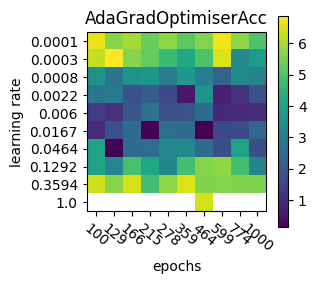

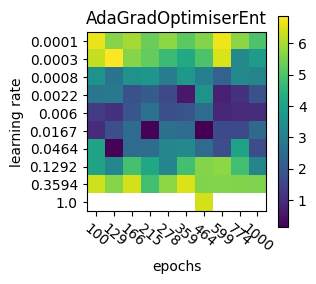

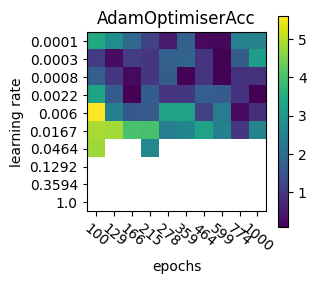

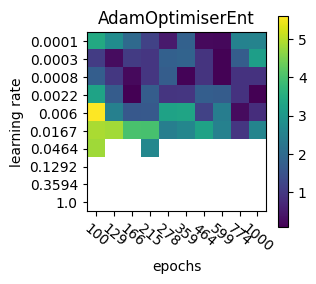

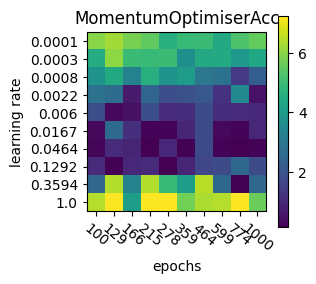

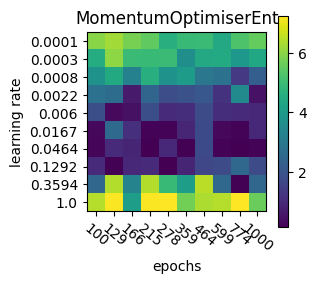

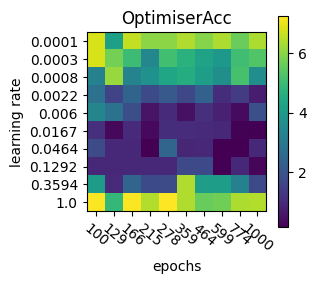

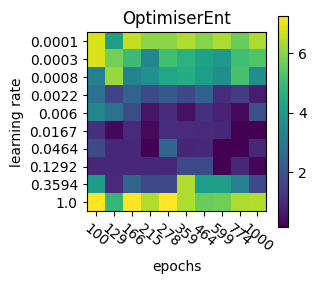

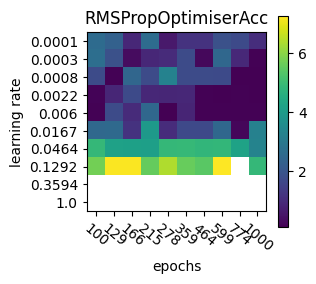

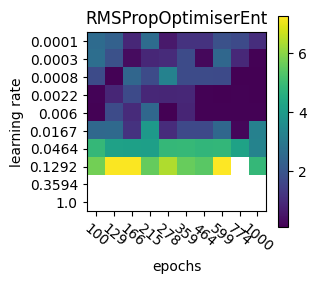

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import os

figsize = (3.313, 3)


def plot_lr_epochs(filename: str, fig_name: str, fig_title: str, savepath: str):
    data = np.load(filename, allow_pickle=True)

    plt.figure(figsize=figsize)
    plt.imshow(data[1:,1:])

    plt.yticks(ticks = np.arange(0, 10, 1), labels = np.round(data[1:, 0], 4))
    plt.xticks(ticks = np.arange(0, 10, 1), labels = map((int), data[0, 1:]), rotation=-40)
    plt.tick_params(axis='y', length=3)
    # plt.xscale("log")
    # plt.yscale("log")
    # plt.ylim(1e-4, 1e2)
    # plt.xlim(1e-4, 1e2)
    plt.xlabel("epochs")
    plt.ylabel("learning rate")

    plt.colorbar()
    plt.title(fig_title)
    plt.tight_layout()
    #plt.savefig(savepath)
    plt.show()



def plot_lamda(filename: str, fig_name: str, fig_title: str):
    data = pd.read_csv(filename)

    fig, ax1 = plt.subplots(figsize=figsize)
    ax2 = ax1.twinx()
    ax1.plot(data, "r--")
    ax2.plot(data, "b--")

    ax1.set_xscale("log")

    ax1.set_xlabel("lambda")
    ax1.set_ylabel("Cross Entropy")
    ax2.set_ylabel("Accuracy")

    fig.title(fig_title)
    fig.savefig(fig_name)
    fig.show()

if __name__ == "__main__":
    base = "Data/NrHidden0/"
    for dir in os.listdir(base):
        for dir2 in os.listdir(base + dir):
            for name in os.listdir(base + dir + '/' + dir2):
                plot_lr_epochs(f'{base}{dir}/{dir2}/{name}', dir2 + name + ".png", f"{dir}{name[:3]}", f"Data/Plots/{dir}{name[:3]}.png")


From these results we choose the following parameters:

Otimiser
$$\text{Lr} = 1$$
$$\text{Epochs} = 278$$
Momentum Optimiser
$$\text{Lr} = 1$$
$$\text{Epochs} = 129$$
AdaGrad
$$\text{Lr} = 0.0003$$
$$\text{Epochs} = 129$$
Adam
$$\text{Lr} = 0.006$$
$$\text{Epochs} = 100$$
RMSProp
$$\text{Lr} = 0.1292$$
$$\text{Epochs} = 129$$

With these we optimize for the regularisation parameter $\lambda$:

In [ ]:
def FixedLrEpoch(L, lr, ep, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, Lmd_range, schedule, t):
    min = 1e8
    max = 0

    Lmd_Cross_ent = np.zeros(len(lr_range), 2)
    Lmd_Acc = np.zeros(len(lr_range)+1, 2)
    Lmd_Cross_ent[1:, 0] = l_range
    Lmd_Acc[1:, 0] = l_range

    for i, Lmd in enumerate(Lmd_range):
        print('.', end='', flush=True)
        if L:
            optimiser = opt(lr, momentum=L)
        else:
            optimiser = opt(lr)

        if schedule:
            model = NN.Model(shapes, [af]*(len(shapes)-1), op.LrScheduleOptimiser(schedule(lr, t), optimiser), lamda=Lmd)
        else:
            model = NN.Model(shapes, [af]*(len(shapes)-1), optimiser, lamda=Lmd)
        inputs = data

        Acc, Cross_Ent = lr_ep_error(n_epoch, nr_batches, inputs, targets, test_data, test_targets, costFunc, model)

        Lmd_Cross_ent[i, 1] = Cross_Ent
        Lmd__Acc[i, 1] = Acc

        if Acc>max:
            max = Acc
            acc_entropy = Cross_Ent
            i_acc_min = i

        if Cross_Ent<min:
            min = Cross_Ent
            Cross_acc = Acc
            i_min = i

    print('\n')
    #k = lr, j = epochs
    return [i_min, min, Cross_acc, i_acc_min, max, acc_entropy, Lmd_Acc, Lmd_Cross_ent]

def RunLambda(L, lr, ep, 22, train, train_tar, test, test_tar, Cross_Entropy, shapes, AF.SoftMax(), opt, name, Lmd_range, t, schedule):
    RL = FixedLrEpocha(L, lr, ep, nr_batches, data, targets, test_data, test_targets, costFunc, shapes, af, opt, Lmd_range, schedule, t)
    Acc_Image = RL[-2]
    Ent_Image = RL[-1]
    min = RL[2]
    max = RL[4]
    print(f't1: {t}, Lmd: {Lmd_range[RL[0]]}, Best Acc: {max}, Best CE: {min}')
    np.save(f'./Data/NrHidden{len(shapes)-2}/{opt.__name__}/Lambda/Acc_{name}', Acc_Image)
    np.save(f'./Data/NrHidden{len(shapes)-2}/{opt.__name__}/Lambda/Ent_{name}', Ent_Image)

def SendToLambda():
Llist = [0, 1.5, 0, 0, 0]
Lrlist = [1, 1, 0.0003, 0.006, 0.1292]
epList = [278, 129, 129, 100, 129]
Lmd_range = np.linspace(0, 10, 100)
shapes = (64, 10)
train, test, val, train_tar, test_tar, val_tar = Data.load_data()
schedules = [lrs.hyperbolic_lr, lrs.hyperbolic_lr, None, None, None]
opts = [op.Optimiser, op.MomentumOptimiser, op.AdaGradOptimiser, op.AdamOptimiser, op.RMSPropOptimiser]
t1 = [215, 464, None, None, None]
    for n_opt, opt in enumerate(opts):
        L = Llist[n_opt]
        schedule = schedules[n_opt]
        t = t1[n_opt]
        Lr = Lrlist[n_opt]
        ep = epList[n_opt]
        name = f't{t}hyperbolic'
        Run(L, lr, ep, 22, train, train_tar, test, test_tar, Cross_Entropy, shapes, AF.SoftMax(), opt, name, Lmd_range, t, schedule)